# SENSE and Noise
Here we show SENSE reconstruction for comparison



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mrsigpy as mrs
from scipy import signal as sig

%matplotlib inline




## Signal
We create a simple 1D signal that consists of a triangle and a half-circle.  This approach could be used with 2D images similarly.



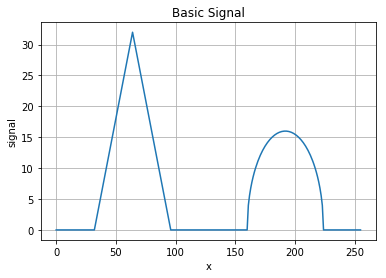

In [2]:
# Create Signal - for next parts
Nx=256

m = np.zeros(Nx)
m[np.int(Nx/8):np.int(Nx/4)]=np.arange(0,Nx/8)       #Ramp up
m[np.int(Nx/4):np.int(3*Nx/8)]=np.arange(Nx/8,0,-1)  #Ramp down
scirc = np.arange(-Nx/8,Nx/8,1)
scirc = np.sqrt(np.power((Nx/8),2)-scirc*scirc)/2      #Semi-circle, half amplitude
m[np.int(5.* Nx/8):np.int(7.* Nx/8)] = scirc   
m = np.expand_dims(m,axis=1)
x = np.arange(0,Nx)
plt.plot(x,m)
mrs.lplot('x','signal','Basic Signal')

Now calculate coil sensitivities.  For now we will have 2 coils with gaussian sensitvity profiles.

csense shape is  (256, 2)
m shape is (256, 1)
csignals shape is  (256, 2)


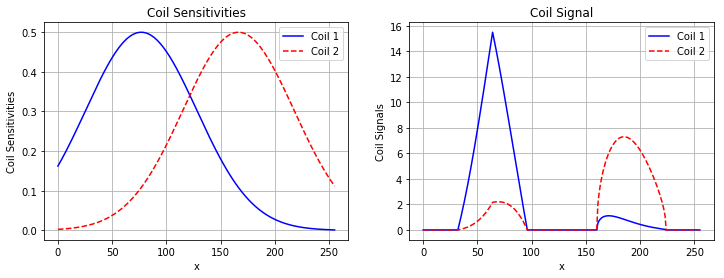

In [3]:
# -- Make gaussian sensitivities
c1 = mrs.gaussian(x,0.3*Nx,Nx/5)     # Left half!
c2 = mrs.gaussian(x,0.65*Nx,Nx/5)   # Right half
# -- Normalize Sensitivities to 0.5 (for illustration)
c1 = c1 / np.max(c1[:])*0.5 
c2 = c2 / np.max(c2[:])*0.5
c1 = np.expand_dims(c1,1)
c2 = np.expand_dims(c2,1)
csens = np.concatenate((c1,c2),axis=1)  

# -- Construct Coil Signals
print("csense shape is ",csens.shape)
print("m shape is",m.shape)
csignals = csens * m    # Broadcasts?
print("csignals shape is ",csignals.shape)

# -- Plot these
fig = plt.figure(figsize=(12.,4.))
plt.subplot(1,2,1)
plt.plot(x,csens[:,0],'b-',label='Coil 1')
plt.plot(x,csens[:,1],'r--',label='Coil 2')
mrs.lplot('x','Coil Sensitivities','Coil Sensitivities')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,csignals[:,0],'b-',label='Coil 1')
plt.plot(x,csignals[:,1],'r--',label='Coil 2')
mrs.lplot('x','Coil Signals','Coil Signal')
plt.legend()

#print ("Shape of c1 is ", (c1.shape))
#print ("Shape of c2 is ", (c2.shape))

## SENSE Formulation
For each pixel with $N_c$ channels and a reduction factor $R$, we assume we have an $N_c \times R$ signal $S_{ij}$, where $i \le N_c$ is the channel, and $j \le R$ are aliased pixels.  

We calculate the sense weights as a $R \times N_c$ matrix $W_{ij}$.

## R=1 SENSE
With no acceleration, the sensitivity calculation will emphasize the coil that has the best sensitivity at a given location.

Image shape is  (256,)
SENSE Weight Calc - 256 pts, 2 coils, R=1
  g-factor term 1 is  6.1596308312332
  g-factor term 2 is  0.16234739181597888
Overall gfactor is  1.0
For pixel 0:
SENSE weight matrix is  [[6.15887506 0.09648835]]
g-factor is  [1.]
  g-factor term 1 is  5.982879808350114
  g-factor term 2 is  0.16714358837767926
Overall gfactor is  1.0
For pixel 1:
SENSE weight matrix is  [[5.9820938  0.09697745]]
g-factor is  [1.]
Size of weights is  (256, 1, 2)
Size of reconstructed signal is  (256, 1)


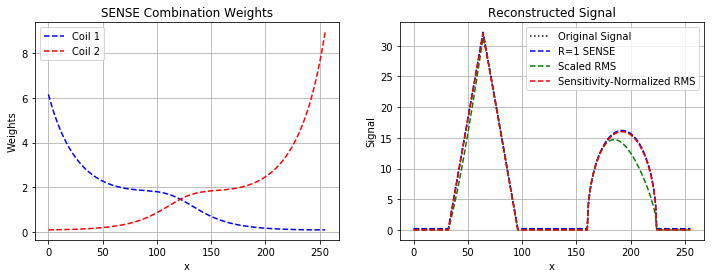

In [4]:
# Add dimension with 1 for R=1 (SENSE needs this to identify R)
csensR1 = np.expand_dims(np.squeeze(csens),axis=2)    # N x 2 x 1
cov = np.eye(2)  # Noise covariance

(cweights,gfactor,noiseR1) = mrs.senseweights(csensR1,noisecov=cov,gfactorcalc=True,noisecalc=True)
print("Size of weights is ",cweights.shape)

sensesig = mrs.senserecon(csignals,cweights)
print("Size of reconstructed signal is ",sensesig.shape)

rmssig = mrs.rmscombine(csignals) * 2
normrmssig = mrs.rmscombine(csignals,csensR1)

fig = plt.figure(figsize=(12.,4.))

plt.subplot(1,2,1)
plt.plot(x,cweights[:,0,0],'b--',label='Coil 1')  # small delta show trace
plt.plot(x,cweights[:,0,1],'r--',label='Coil 2')  # small delta show trace
mrs.lplot('x','Weights','SENSE Combination Weights')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,m+.1,'k:',label='Original Signal')  # small delta show trace
plt.plot(x,sensesig+.2,'b--',label='R=1 SENSE')
plt.plot(x,rmssig,'g--',label='Scaled RMS')
plt.plot(x,normrmssig,'r--',label='Sensitivity-Normalized RMS')
mrs.lplot('x','Signal','Reconstructed Signal')
plt.legend()

## Results
### Sensitivities
We normalized the sensitivities to 0.5.  In the region where the sensitivity peaks (about 25% and 75% across) the active coil has a weight of 2, as expected.  At the left/right edges, the coil with zero-sensitivity has a weight of zero as expected.
### Image
Note that the SENSE combination reconstructs the signal perfectly.  If we know the coil sensitivities, so does the sensitivity-normalized RMS.  (These will differ with noise...)  Without sensitivities, the RMS has a "shading" as here there is a constant scale just for comparison.



## Addition of Noise
Now we will add noise to the signals and repeat the reconstruction.

Size of cnoise is  (256, 2)
Size of reconstructed signal is  (256, 1)


/Users/brian/Box Sync/Brian's Externally Shareable Files/Rad229-2018/Code/Python/mrsigpy.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  sigout[i,:] = np.matmul(wi,sigi)
/Users/brian/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


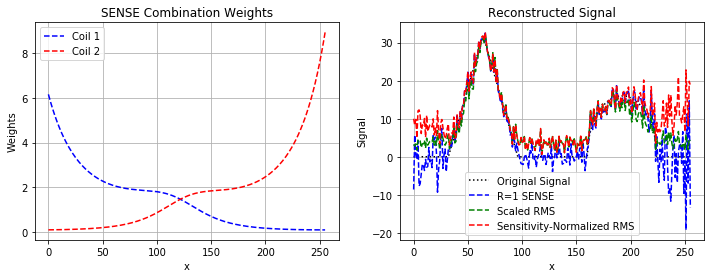

In [5]:
# -- Generate Multivariate noise
cnoise = np.random.multivariate_normal(np.zeros(2),cov,(Nx)) + 1j*np.random.multivariate_normal(np.zeros(2),cov,(Nx))
print("Size of cnoise is ",cnoise.shape)

# -- Add noise!
cnoisysignals = csignals + cnoise

# -- SENSE Reconstruction
sensesig = mrs.senserecon(cnoisysignals,cweights)
print("Size of reconstructed signal is ",sensesig.shape)

# -- RMS Reconstruction
rmssig = mrs.rmscombine(cnoisysignals) * 2
normrmssig = mrs.rmscombine(cnoisysignals,csens)

fig = plt.figure(figsize=(12.,4.))

plt.subplot(1,2,1)
plt.plot(x,cweights[:,0,0],'b--',label='Coil 1')  # small delta show trace
plt.plot(x,cweights[:,0,1],'r--',label='Coil 2')  # small delta show trace
mrs.lplot('x','Weights','SENSE Combination Weights')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,m,'k:',label='Original Signal')  # small delta show trace
plt.plot(x,sensesig,'b--',label='R=1 SENSE')
plt.plot(x,rmssig,'g--',label='Scaled RMS')
plt.plot(x,normrmssig,'r--',label='Sensitivity-Normalized RMS')
mrs.lplot('x','Signal','Reconstructed Signal')
plt.legend()

## Results 
Now we see that the reconstruction has some noise.  The SENSE noise seems worse where the combination weights are higher (not surprising!).  The RMS combination has a bias, whereas SENSE does not (middle).  And the normalized RMS amplifies noise (left and right).



## R=2 SENSE
Now we will undersample and use SENSE to unalias the data.

Image shape is  (128,)
SENSE Weight Calc - 128 pts, 2 coils, R=2
  g-factor term 1 is  8.003395501568576
  g-factor term 2 is  0.16234739181597888
Overall gfactor is  1.2993303853513962
  g-factor term 1 is  2.6835952657132705
  g-factor term 2 is  0.4841752413086212
Overall gfactor is  1.2993303853513962
For pixel 0:
SENSE weight matrix is  [[ 6.23892315 -5.01300085]
 [-0.04203753  2.68326599]]
g-factor is  [1.29933039 1.29933039]
  g-factor term 1 is  7.672383149243074
  g-factor term 2 is  0.16714358837767926
Overall gfactor is  1.282389650972927
  g-factor term 1 is  2.645098726137149
  g-factor term 2 is  0.4848173107117646
Overall gfactor is  1.282389650972927
For pixel 1:
SENSE weight matrix is  [[ 6.05994943 -4.70557925]
 [-0.04287483  2.64475122]]
g-factor is  [1.28238965 1.28238965]
Size of weights is  (256, 1, 2)
Size of weights to plot is  (256, 2)
Size of reconstructed signal is  (128, 2)


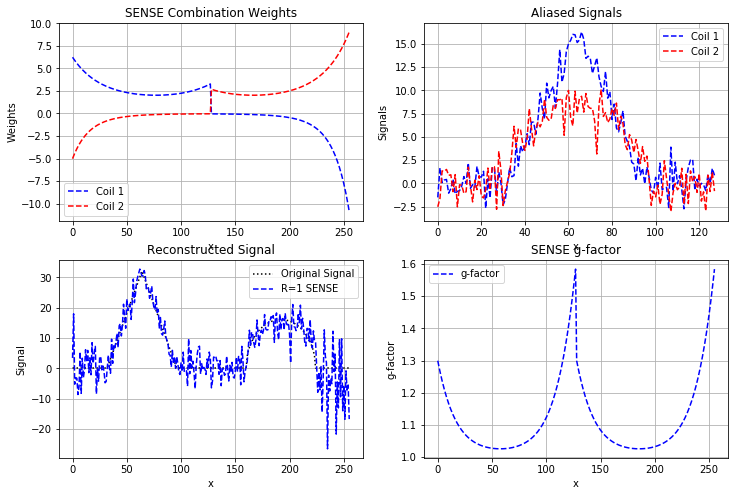

In [6]:
# Modify coil sensitivities for R=1
csensR2 = np.expand_dims(np.squeeze(csens),axis=2)    
# Nx x 2coils x 1 --> Nx/2 x 2coils x R=2
halfNx = np.int(Nx/2)
halfx = x[0:halfNx]
csensR2 = np.concatenate((csensR2[0:halfNx,:,:],csensR2[halfNx:,:,:]),axis=2)


(cweightsR2,gfactorR2,noiseR2) = mrs.senseweights(csensR2,noisecov=cov,gfactorcalc=True,noisecalc=True)
print("Size of weights is ",cweights.shape)
# Organize weights for plot.
cweightsplt = np.reshape(cweightsR2,(Nx,2),order='F')  
cweightsplt = np.squeeze(cweightsplt)
print("Size of weights to plot is ",cweightsplt.shape)
gfactorplt = np.reshape(gfactorR2,(Nx,1),order='F')
noiseR2 = np.reshape(noiseR2,(Nx,1),order='F')


# Alias the signals
csignalsR2 = cnoisysignals[0:halfNx,:]+cnoisysignals[halfNx:,:]

#cweights = np.ones((halfNx,2,2))  # -- Just alias signals for testing!
sensesig = mrs.senserecon(csignalsR2,cweightsR2)
print("Size of reconstructed signal is ",sensesig.shape)
sensesig = np.reshape(sensesig,(Nx,-1),order='F')  
#sensesig = np.concatenate((sensesig[:,0],sensesig[:,1]),axis=0)

fig = plt.figure(figsize=(12.,8.))

plt.subplot(2,2,1)
plt.plot(x,cweightsplt[:,0],'b--',label='Coil 1')  # small delta show trace
plt.plot(x,cweightsplt[:,1],'r--',label='Coil 2')  # small delta show trace
mrs.lplot('x','Weights','SENSE Combination Weights')
plt.legend()

plt.subplot(2,2,2)
plt.plot(halfx,csignalsR2[:,0],'b--',label='Coil 1')  # small delta show trace
plt.plot(halfx,csignalsR2[:,1],'r--',label='Coil 2')  # small delta show trace
mrs.lplot('x','Signals','Aliased Signals')
plt.legend()

plt.subplot(2,2,3)
plt.plot(x,m+.1,'k:',label='Original Signal')  # small delta show trace
plt.plot(x,sensesig+.2,'b--',label='R=1 SENSE')
mrs.lplot('x','Signal','Reconstructed Signal')
plt.legend()

plt.subplot(2,2,4)
plt.plot(x,gfactorplt,'b--',label='g-factor')
mrs.lplot('x','g-factor','SENSE g-factor')
plt.legend()




### SENSE Noise
Because noise in SENSE is additive, we can reconstruct only the noise, and plot it.  As expected it is higher at the edges for R=1.  For R=1 it also peaks in the middle, and is periodic.  

We can predict the noise from SENSE in two ways.  
1. Directly calculate noise using the sensitivity matrix.
2. Do a multiple noise propagation approach.


### G-factor
The g-factor tells us about noise amplification due to using coils to unalias signal, but in the case of R=1 SENSE, the g-factor is 1.



Size of cnoise is  (25600, 2)


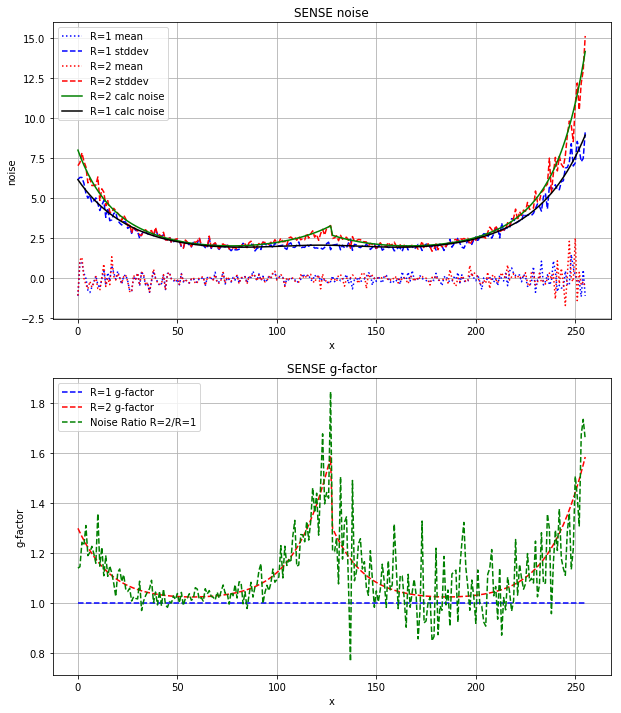

In [7]:
# -- Generate Multivariate noise
Nnoise = 100  # multiple runs for noise
cnoise = np.random.multivariate_normal(np.zeros(2),cov,(Nx*Nnoise)) + 1j*np.random.multivariate_normal(np.zeros(2),cov,(Nx*Nnoise))
print("Size of cnoise is ",cnoise.shape)

cnoise = np.reshape(cnoise,(Nx,2,Nnoise),order='F')

sigR1 = np.zeros((Nx,Nnoise))
sigR2 = np.zeros((Nx,Nnoise))

for n in range(0,Nnoise):
  # -- SENSE Reconstruction of noise only!
  sensesig = mrs.senserecon(cnoise[:,:,n],cweights)
  sigR1[:,n] = np.squeeze(sensesig)

  # -- For R=2, just use half the signal(noise)
  sensesigR2 = mrs.senserecon(cnoise[0:halfNx,:,n],cweightsR2)
  # -- Reshape to image size.
  sensesigR2 = np.reshape(sensesigR2,(Nx,1),order='F')
  sigR2[:,n] = np.squeeze(sensesigR2)
    
sigR1mean = np.mean(sigR1,axis=1)
sigR1std = np.std(sigR1,axis=1)
sigR2mean = np.mean(sigR2,axis=1)
sigR2std = np.std(sigR2,axis=1)

gfactexp = sigR2std / sigR1std


fig = plt.figure(figsize=(10.,12.))
plt.subplot(2,1,1)
plt.plot(x,sigR1mean,'b:',label='R=1 mean')  # small delta show trace
plt.plot(x,sigR1std,'b--',label='R=1 stddev')  # small delta show trace
plt.plot(x,sigR2mean,'r:',label='R=2 mean')  # small delta show trace
plt.plot(x,sigR2std,'r--',label='R=2 stddev')  # small delta show trace
plt.plot(x,noiseR2,'g-',label='R=2 calc noise')
plt.plot(x,noiseR1,'k-',label='R=1 calc noise')

mrs.lplot('x','noise','SENSE noise')
plt.legend()


plt.subplot(2,1,2)
plt.plot(x,gfactor,'b--',label='R=1 g-factor')  # small delta show trace
plt.plot(x,gfactorplt,'r--',label='R=2 g-factor')  # small delta show trace
plt.plot(x,gfactexp,'g--',label='Noise Ratio R=2/R=1')
mrs.lplot('x','g-factor','SENSE g-factor')
plt.legend()

## Results
Noise is greater at the edges due to coil sensitivity dropoff.  g-factor is periodic.  Noise calculation by multiple propagation agrees very well with direct noise calculation, as well as g-factor for comparing R=1 to R=2.

_Why is noise estimation more noisy on right half??_

